<a href="https://colab.research.google.com/github/VegaSera/SlayTheSpireAnalysisAndModelling/blob/master/Slay_The_Spire_Predictive_Modeling_And_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import requests
import os, sys
import shap

In [3]:
#Config Cell - 

filepath = 'drive/My Drive/STSDATA/'

#Must be one of 'IRONCLAD', 'THE_SILENT', 'DEFECT', 'WATCHER', or None
#None type will combine all classes.
stsclass = 'IRONCLAD'

#Number of JSON files to add to dataframe, reduce in case of RAM or time issues.
number_of_files = 600

#Printing out the amount of files in the filepath, to make sure everything is ready.
len(os.listdir(filepath))

1003

In [0]:
def extract_class_data(filename, stsclass=None):
  """
  Extracts data from JSON files.
  Returns a dataframe with the specified class, and separates out seeded and endless runs.
  """
  data = json.load(open(filename))
  data = json_normalize(data=data)
  df = pd.DataFrame(data=data)
  df.columns = [i.replace('event.', '') for i in df.columns]

  if stsclass is not None: #If a class is specified, returns a dataframe with only that class. Otherwise all classes are returned.
    df = df[df['character_chosen'] == stsclass]

  df = df[(df['chose_seed'] == False) & (df['is_endless'] == False)] #Always dropping seeded and endless runs.

  return df

In [0]:
def compile_dataframe(stsdf, num_files, stsclass=None):
  """
  Compiles a dataframe from a folder with jsons.

  stsdf - Dataframe to append new results to.
  num_files - Max number of files to iterate over
  stsclass - Desired character class. If none, will use all character classes.
  """

  num=0
  total_amount_files = len([i for i in os.listdir(filepath)])

  if num_files > total_amount_files:
    print(f'Number of files specified is greater than number of files available. Only processing {total_amount_files} files.')
    iters = total_amount_files
  else:
    print(f'Processing {num_files} files.')
    iters = num_files
  
  for file in os.listdir(filepath):
    if not file.startswith('2'): #We have some output files saved in this folder as well. All of our input jsons start with a 2.
      pass #Simply skips the files we dont care about.
    elif num > iters:
      break #If the number of iterations is greater than our given value, break from the loop.
    else:
      stsdf = stsdf.append(extract_class_data(f'{filepath}{file}', stsclass), sort=False, ignore_index=True)
      num += 1
      print(f'{file} done, {num}/{iters}')
  
  stsdf.reset_index()
  return stsdf

In [0]:
def listify(string):
  """
  Takes a string in a specific format, such as "['Burning Blood', 'War Paint', 'Dream Catcher', 'Regal Pillow', 'Mark of Pain', 'Shovel', 'Omamori']"
  Removes the brackets, spaces, and quotes, and returns a python list.
  """
  string = str(string)
  new_string = string.replace('[', '').replace(']', '').replace("'","").replace('"',"").replace(" ","_").replace(",_", ",")
  #First two replaces get rid of brackets. Third and Fourth gets rid of quotes. Fifth replaces whitespace with underscores, sixth removes leading underscores.
  newlist = new_string.split(",") #Splits the string and creates a proper list.
  return newlist

In [0]:
def column_engineering(stsdf):
  '''
  First, gathers a list of individual entries in master_deck and relics.
  Applies a prefix to each entry. 'CARD_' for cards. 'RELIC_' for relics.
  For every individual entry, creates a new column in the dataframe.
  Finally inputs the correct value into each column.
  '''
  deck_list = []
  relic_list = []
  for index, row in stsdf.iterrows():
    if index % 5000 == 0:
      print(f'{index}/{len(stsdf)}') #Heartbeat check and progress monitor
    deck_list = list(set(deck_list)|set(row[0]))
    relic_list = list(set(relic_list)|set(row[1]))

  #Applying prefixes
  print('Applying prefixes.')
  deck_list = ["CARD_" + s for s in deck_list]
  relic_list = ["RELIC_" + s for s in relic_list]

  #Combining our lists
  total_list = deck_list + relic_list

  #Adds all of our new columns, and sets the value in every row to 0. We will fix this in the next step.
  print(f'Applying {len(total_list)} new columns')
  for col in total_list:
    stsdf[col] = pd.Series([0 for x in range(len(stsdf))])

  #If the card/relic exists in master_deck or relics, set the corresponding column to 1.
  print('Imputing values from master_deck and relics.')
  for index, row in stsdf.iterrows():
    for card in row[0]:
      stsdf.at[index, ('CARD_'+card)] = 1
    for relic in row[1]:
      stsdf.at[index, ('RELIC_'+relic)] = 1
  
  print('Done.')
  return stsdf
  

In [0]:
def drop_prismatic_shard(stsdf):
  '''
  Drops rows with the prismatic shard relic and all empty columns that result from dropping it.
  May expand later to include class specific cards.
  '''
  print('Dropping Prismatic Shard')
  stsdf = stsdf[stsdf['RELIC_PrismaticShard'] == 0]
  for col in stsdf.columns[2:]: #Cannot pass columns with lists into the next line. Slicing those out.
    if len(stsdf[col].unique()) == 1: #If a column is all 0s, we drop it. 
      stsdf = stsdf.drop(col, axis=1)
  
  return stsdf

In [8]:
initial_file = f'{filepath}2019-06-22-16-47#1199.json' #Setting an initial file to get a dataframe we can append to

df = extract_class_data(initial_file, stsclass)
df = compile_dataframe(df, number_of_files, stsclass=stsclass)

if os.path.exists(f'{filepath}sts_{stsclass}_{len(df)}.csv'):
  pass
else: #If our file does not already exist, save it to a CSV
  print(f'Saving dataframe to {filepath}sts_{stsclass}_{len(df)}.csv')
  df.to_csv(f'{filepath}sts_{stsclass}_{len(df)}.csv')
  print('CSV successfully saved.')

KeyboardInterrupt: ignored

In [0]:
#Reset runtime and load in a CSV here to save on memory, if necessary.
imported_file = f'{filepath}sts_IRONCLAD_295740.csv'
df = pd.read_csv(imported_file) 

In [0]:
df = df[['master_deck', 'relics', 'ascension_level', 'victory']] #Removes the columns we dont care about.
df = df.dropna() #Removes rows with NaNs.
df.master_deck = df.master_deck.apply(listify)
df.relics = df.relics.apply(listify)

In [11]:
df = column_engineering(df)
df = drop_prismatic_shard(df)
df.victory = df.victory.astype(bool)

0/295740
5000/295740
10000/295740
15000/295740
20000/295740
25000/295740
30000/295740
35000/295740
40000/295740
45000/295740
50000/295740
55000/295740
60000/295740
65000/295740
70000/295740
75000/295740
80000/295740
85000/295740
90000/295740
95000/295740
100000/295740
105000/295740
110000/295740
115000/295740
120000/295740
125000/295740
130000/295740
135000/295740
140000/295740
145000/295740
150000/295740
155000/295740
160000/295740
165000/295740
170000/295740
175000/295740
180000/295740
185000/295740
190000/295740
195000/295740
200000/295740
205000/295740
210000/295740
215000/295740
220000/295740
225000/295740
230000/295740
235000/295740
240000/295740
245000/295740
250000/295740
255000/295740
260000/295740
265000/295740
270000/295740
275000/295740
280000/295740
285000/295740
290000/295740
295000/295740
Applying prefixes.
Applying 695 new columns
Imputing values from master_deck and relics.
Done.
Dropping Prismatic Shard


#Fitting our models

In [12]:
#First, the train-validate-test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df.drop(['master_deck', 'relics'], axis=1), test_size = 0.1)
train, val = train_test_split(train, test_size = 0.1)

train.shape, val.shape, test.shape

((237354, 524), (26373, 524), (29304, 524))

In [13]:
#Baseline
train.victory.value_counts(normalize=True)

False    0.924442
True     0.075558
Name: victory, dtype: float64

In [0]:
target = 'victory'

x_train = train.drop(columns=target)
y_train = train[target]
x_val = val.drop(columns=target)
y_val = val[target]
x_test = test.drop(columns=target)
y_test = test[target]

In [0]:
#Accuracy function
from sklearn.metrics import accuracy_score

def model_accuracy(model):
  y_pred = model.predict(x_val)
  print('Validation Accuracy', accuracy_score(y_val, y_pred))
  y2_pred = model.predict(x_test)
  print('Test Accuracy', accuracy_score(y_test, y2_pred))

In [15]:
!pip install eli5

In [0]:
#Quick permutation importance function for later
import eli5
from eli5.sklearn import PermutationImportance

def permutation_importances(model, top=50):
  permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=10
  )

  print('Permuter starting to fit')
  permuter.fit(x_val, y_val)
  print('Permuter finished fitting.')

  feature_names = x_val.columns.tolist()
  pd.Series(permuter.feature_importances_, feature_names).sort_values()

  return eli5.show_weights(
    permuter, 
    top=top,
    feature_names=feature_names
  )

In [0]:
test_index = 1142 #Random number that refers to the row index of our test dataframe.

In [0]:
def model_predictions(model, top=40, doc=test_index):
  print('True Result - ', y_test.iloc[test_index])
  predictions = eli5.show_prediction(
      model,
      top=top,
      doc=x_test.iloc[test_index]
  )
  return eli5.formatters.html.format_as_html(predictions, include_styles=False)

##Model 1 - Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 25, min_samples_split=4, max_depth=20)

rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
model_accuracy(rf_model)

Validation Accuracy 0.9285633033784553
Test Accuracy 0.9296000546000546


In [49]:
permutation_importances(rf_model)

Permuter starting to fit
Permuter finished fitting.


Weight,Feature
0.0012 ± 0.0002,CARD_Barricade+1
0.0008 ± 0.0004,CARD_Battle_Trance+1
0.0008 ± 0.0002,CARD_Body_Slam+1
0.0008 ± 0.0004,CARD_Shrug_It_Off+1
0.0007 ± 0.0002,CARD_Offering+1
0.0006 ± 0.0002,CARD_Metallicize+1
0.0005 ± 0.0002,CARD_Inflame+1
0.0004 ± 0.0003,CARD_Bash
0.0004 ± 0.0002,CARD_Flex+1
0.0004 ± 0.0001,CARD_Entrench+1


In [22]:
model_predictions(rf_model)

True Result -  False


##Model 2 - Gradient Boosting with XGBClassifier

In [26]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=75)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=75, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [27]:
model_accuracy(xgb_model)

Validation Accuracy 0.9329238236074774
Test Accuracy 0.933046683046683


In [50]:
permutation_importances(xgb_model)

Permuter starting to fit
Permuter finished fitting.


Weight,Feature
0.0014 ± 0.0003,CARD_Barricade+1
0.0014 ± 0.0001,CARD_Shockwave+1
0.0013 ± 0.0003,CARD_Offering+1
0.0012 ± 0.0006,CARD_Strike_R
0.0012 ± 0.0003,CARD_Battle_Trance+1
0.0012 ± 0.0005,CARD_Shrug_It_Off+1
0.0011 ± 0.0002,CARD_Demon_Form+1
0.0011 ± 0.0004,CARD_Body_Slam+1
0.0011 ± 0.0003,CARD_Limit_Break+1
0.0009 ± 0.0003,CARD_Inflame+1


In [28]:
model_predictions(xgb_model)

True Result -  False


##Model 3 - Linear Ridge Classification with RidgeClassifierCV

In [21]:
from sklearn.linear_model import RidgeClassifierCV

ridge_model = RidgeClassifierCV(cv=5)
ridge_model.fit(x_train, y_train)

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=5,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False)

In [22]:
model_accuracy(ridge_model)

Validation Accuracy 0.939483562734615
Test Accuracy 0.9416120666120666


In [51]:
permutation_importances(ridge_model)

Permuter starting to fit
Permuter finished fitting.


Weight,Feature
0.0015 ± 0.0004,CARD_Limit_Break+1
0.0013 ± 0.0004,CARD_Battle_Trance+1
0.0012 ± 0.0003,CARD_Offering+1
0.0011 ± 0.0004,RELIC_Self_Forming_Clay
0.0010 ± 0.0002,RELIC_Dead_Branch
0.0010 ± 0.0004,CARD_Strike_R
0.0009 ± 0.0003,RELIC_Fusion_Hammer
0.0008 ± 0.0003,CARD_Barricade+1
0.0007 ± 0.0003,RELIC_Vajra
0.0007 ± 0.0003,RELIC_Bag_of_Preparation


In [23]:
model_predictions(ridge_model)

True Result -  False


Separate area for testing model predictions

In [0]:
test_index = 1255

In [41]:
model_predictions(rf_model)

True Result -  True


In [39]:
model_predictions(xgb_model)

True Result -  True


In [40]:
model_predictions(ridge_model)

True Result -  True


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


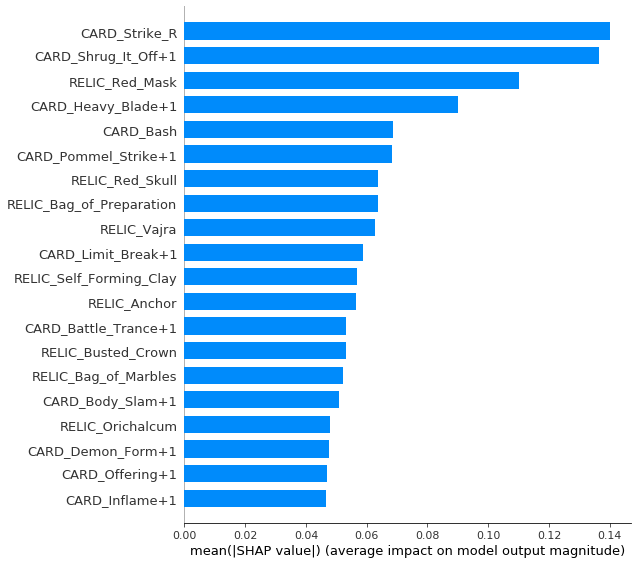

In [44]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [0]:
def ABS_SHAP(df_shap,df):
    import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'blue','red')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(15,120),legend=False)
    ax.set_xlabel("SHAP Value (Blue = Positive Impact)")
    
#ABS_SHAP(shap_values,x_train)

invalid value encountered in true_divide
invalid value encountered in true_divide


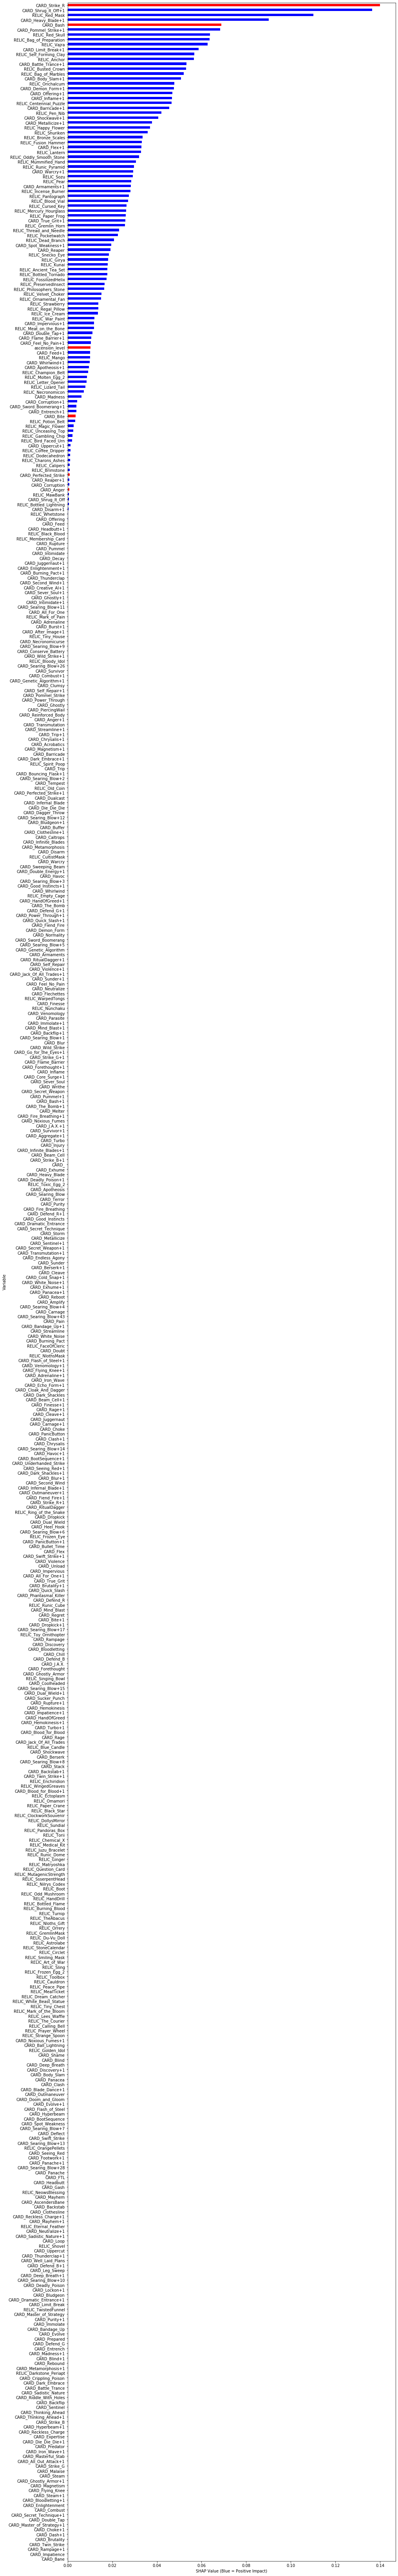

In [46]:
ABS_SHAP(shap_values,x_train)